In [1]:
import pandas as pd
import numpy as np


In [2]:
# Load data dengan memastikan konsistensi kolom
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

Kolom di X_train: Index(['Destination Port', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Max Packet Length', 'Min Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Avg Bwd Segment Size', 'Average Packet Size'],
      dtype='object')
Kolom di X_test: Index(['Destination Port', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Max Packet Length', 'Min Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Avg Bwd Segment Size', 'Average Packet Size'],
      dtype='object')
Shape of X_train_reshaped: (156594, 1, 11)
Shape of X_test_reshaped: (45149, 1, 11)


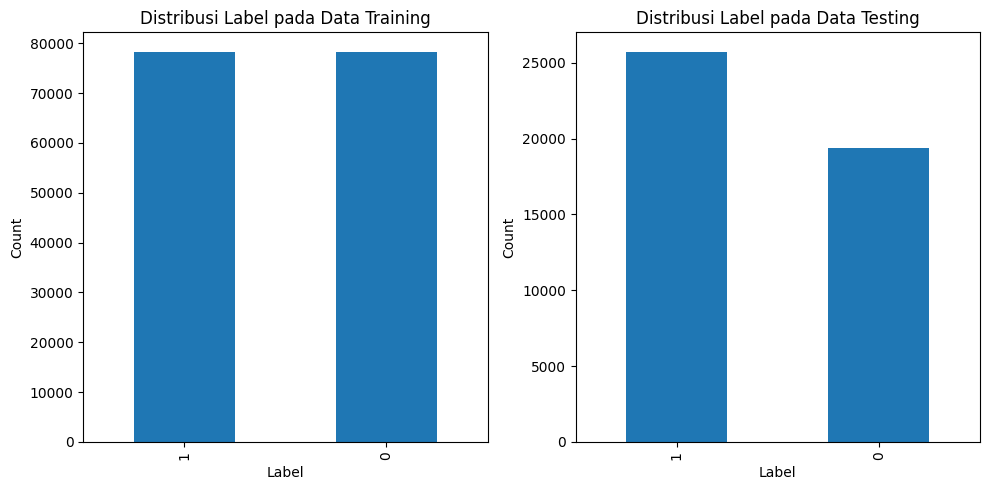

In [3]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Bersihkan nama kolom dengan menghapus spasi ekstra di awal/akhir
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Pisahkan fitur dan label
X_train = df_train[[ 'Destination Port', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Max Packet Length',
       'Min Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'Avg Bwd Segment Size', 'Average Packet Size']]
y_train = df_train['Label']

X_test = df_test.drop('Label', axis=1)
y_test = df_test['Label']

# Pastikan kolom fitur konsisten
print("Kolom di X_train:", X_train.columns)
print("Kolom di X_test:", X_test.columns)

# Pastikan tidak ada kolom yang hilang
missing_in_test = set(X_train.columns) - set(X_test.columns)
missing_in_train = set(X_test.columns) - set(X_train.columns)

if missing_in_test or missing_in_train:
    raise ValueError(f"Kolom tidak konsisten!\nMissing in test: {missing_in_test}\nMissing in train: {missing_in_train}")

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit scaler pada data training saja
X_train_scaled = scaler.fit_transform(X_train)

# Transform data test dengan scaler yang sama
X_test_scaled = scaler.transform(X_test)

# Reshape data menjadi bentuk [samples, timesteps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Tampilkan shape dari data yang telah di-reshape
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

# Plot distribusi label
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar')
plt.title('Distribusi Label pada Data Training')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar')
plt.title('Distribusi Label pada Data Testing')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [10]:
from keras.layers import Reshape

model = Sequential(
    [
        LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras.optimizers import Adam

# Compile the model with Adam optimizer and a learning rate of 0.00001
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
train = model.fit(X_train_reshaped,y_train, epochs=10, batch_size=32, validation_split=0.2)
train

Epoch 1/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6132 - loss: 0.6686 - val_accuracy: 0.7856 - val_loss: 0.5235
Epoch 2/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7896 - loss: 0.4923 - val_accuracy: 0.8033 - val_loss: 0.4163
Epoch 3/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8000 - loss: 0.4089 - val_accuracy: 0.8033 - val_loss: 0.3595
Epoch 4/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8012 - loss: 0.3496 - val_accuracy: 0.7938 - val_loss: 0.3055
Epoch 5/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7795 - loss: 0.2994 - val_accuracy: 0.8860 - val_loss: 0.2647
Epoch 6/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8452 - loss: 0.2641 - val_accuracy: 0.8795 - val_loss: 0.2401
Epoch 7/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8743 - loss: 0.2397 - val_accuracy: 0.8827 - val_loss: 0.2240
Epoch 8/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8840 - loss: 0.2257

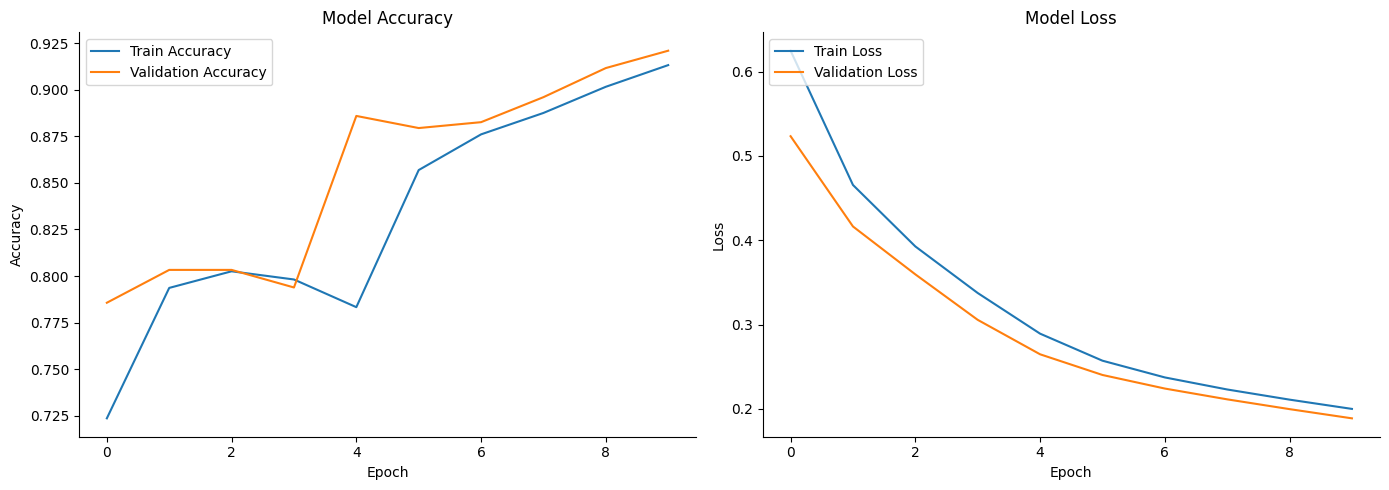

In [14]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Train Accuracy')
plt.plot(train.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
sns.despine()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Train Loss')
plt.plot(train.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
sns.despine()

plt.tight_layout()
plt.show()

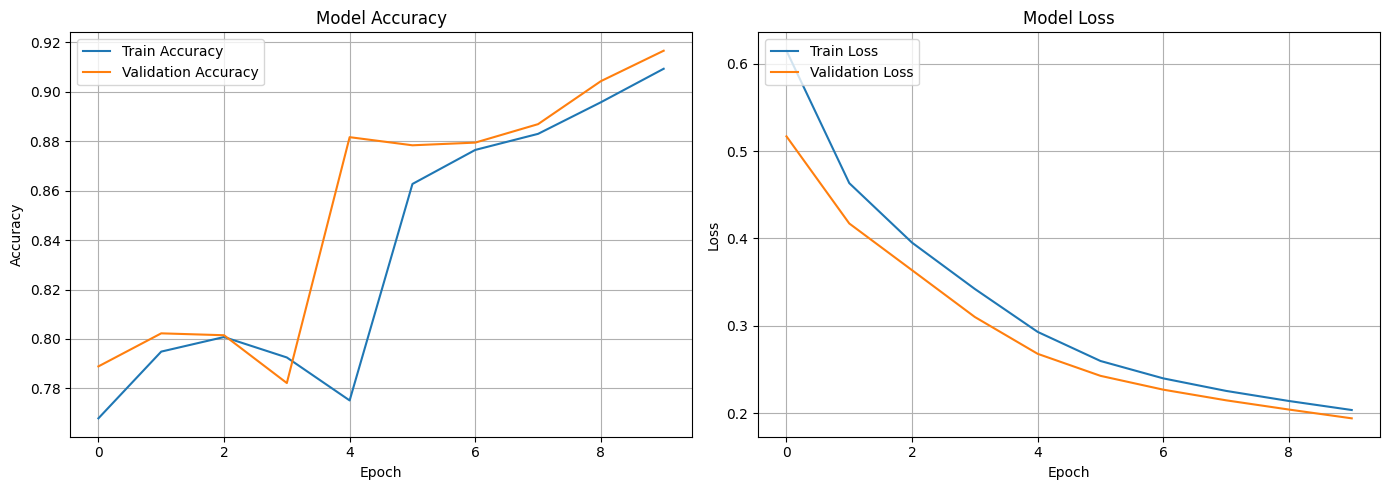

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Train Accuracy')
plt.plot(train.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Train Loss')
plt.plot(train.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import f1_score

# Pisahkan fitur dan label untuk df_test
X_test = df_test.drop('Label', axis=1)
y_test = df_test['Label']

# Normalisasi fitur menggunakan scaler yang telah dilatih
X_test_scaled = scaler.transform(X_test)

# Reshape data menjadi bentuk [samples, timesteps, features]
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Lakukan prediksi menggunakan model yang telah dilatih
y_pred = model.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int)

# Hitung f1-score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
F1 Score: 0.9394758963488177


In [20]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=['Kelas 0', 'Kelas 1'])
print(report)

              precision    recall  f1-score   support

     Kelas 0       1.00      0.83      0.91     19417
     Kelas 1       0.89      1.00      0.94     25732

    accuracy                           0.93     45149
   macro avg       0.94      0.91      0.92     45149
weighted avg       0.93      0.93      0.93     45149

